In [1]:
"""author: Vetivert? 💐 
created: 17/04/2025 @ 15:16:47"""

from sklearn.model_selection import train_test_split # type: ignore

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
from src.utils.models import *
from src.utils.functions import *

## Prepare Data

In [2]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)
df.index = range(len(df)) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df.iloc[np.where(df == '8(nặng xin về)')] = 8

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(HEMATOMA_COLS[0]), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(BLEEDING_COLS[0]), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.4, '2': 39.66, '3': 3.94}


## symptom data 2019

### split data

In [3]:
df_set = df.loc[222:, :'Oliguria'].copy().fillna(0)

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set.drop(columns=['Diagnosis']), df_set['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df_set['Diagnosis'])
x1_features = x1_train.columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (147, 24) y1_train shape:  (147,)
x1_test shape:  (37, 24) y1_test shape:  (37,)
percentage of classes:  {'1': 45.95, '2': 54.05}


### RF

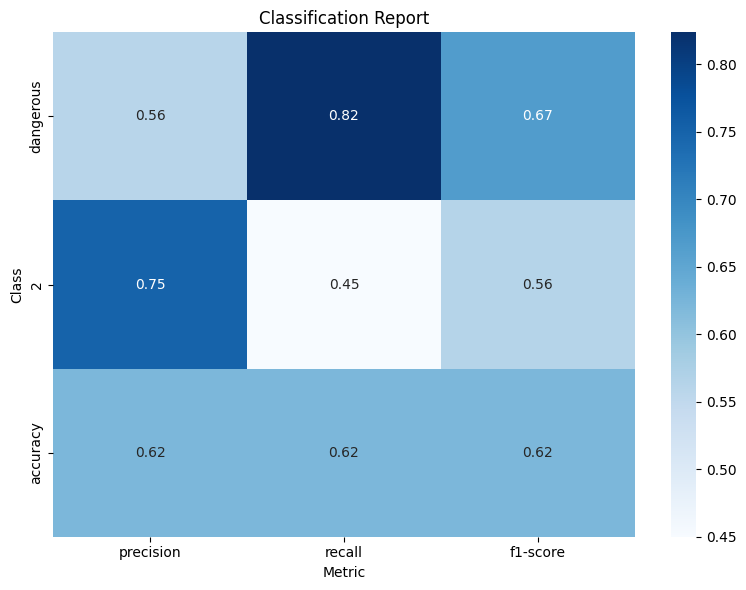

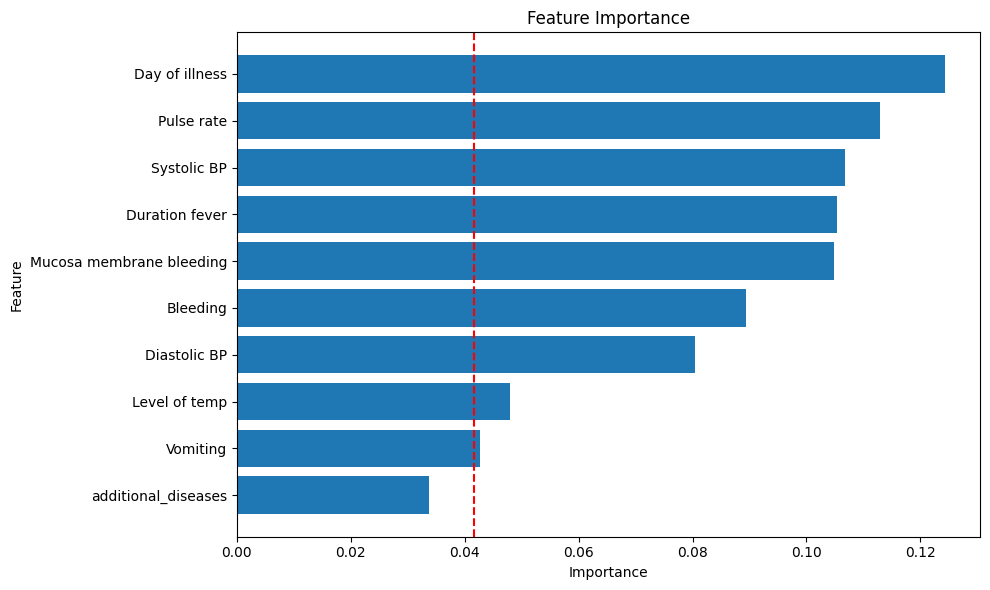

In [5]:
rf_model = RandomForestModel(n_estimators=100, random_state=66)
rf_model.fit(x1_train, y1_train)
rf_metrics = rf_model.evaluate(x1_test, y1_test)
# print("RF Performance:", rf_metrics)

rf_model.plot_feature_importance(x1_train)

### XGBoost

In [4]:
x1_train_np = x1_train.to_numpy()
y1_train_np = y1_train.to_numpy()
x1_test_np = x1_test.to_numpy()
y1_test_np = y1_test.to_numpy()

for i in range(len(y1_train_np)):
    if y1_train_np[i] == '1':
        y1_train_np[i] = 0
    elif y1_train_np[i] == '2':
        y1_train_np[i] = 1  

for i in range(len(y1_test_np)):
    if y1_test_np[i] == '1':
        y1_test_np[i] = 0
    elif y1_test_np[i] == '2':
        y1_test_np[i] = 1  

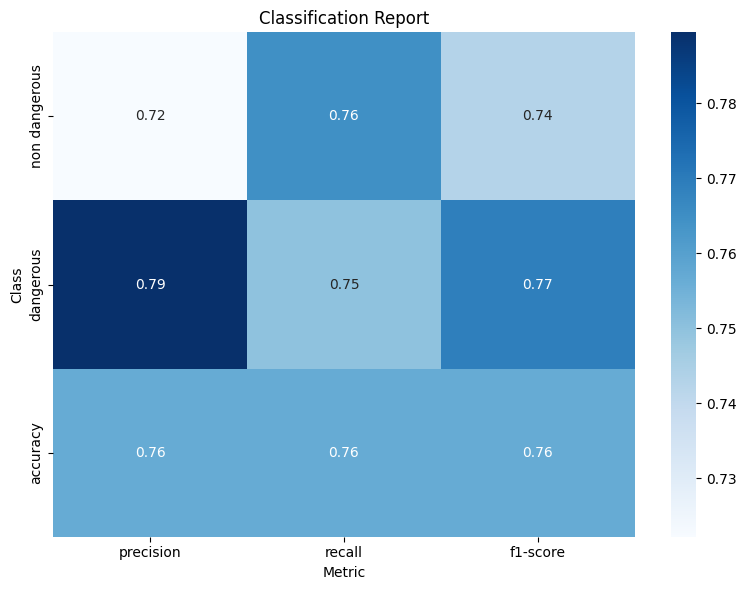

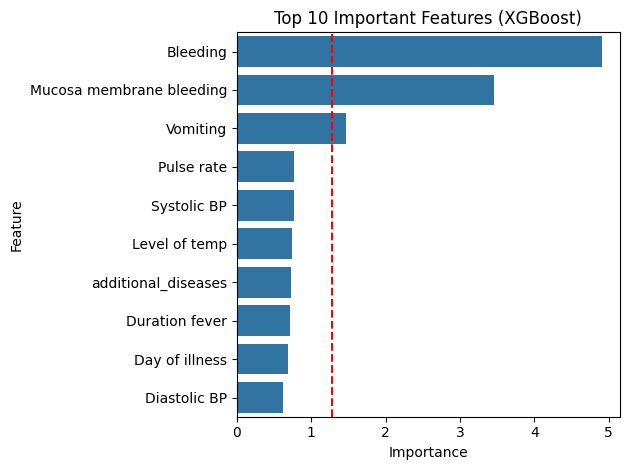

In [5]:
xgb_model = XGBoostModel(n_estimators=100, random_state=66)
xgb_model.fit(x1_train_np, y1_train_np)
xgb_metrics = xgb_model.evaluate(x1_test_np, y1_test_np)
# print("XGBoost Performance:", xgb_metrics)

xgb_model.plot_feature_importance(x_features=x1_features)

## blood indexes ALT AST PLT

In [ ]:
df_alt_ast = df.loc[:, 'Glu1':'GGT9'].copy()
# print(df_alt_ast['AST1'])
alt_df = pd.DataFrame()
ast_df = pd.DataFrame()
for i in range(9):
    col_1 = 'ALT' + str(i+1)
    alt_df[col_1] = df_alt_ast[col_1]

    col_2 = 'AST' + str(i+1)
    ast_df[col_2] = df_alt_ast[col_2]
# print(ast_df)

alt_df = alt_df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
ast_df = ast_df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
# print(alt_df)
alt_df[0] = alt_df[0].str.replace(',', '.').astype(float)
alt_df[0].fillna(alt_df[0].mean(), inplace=True)

ast_df[0] = ast_df[0].str.replace(',', '.').astype(float)
ast_df[0].fillna(ast_df[0].mean(), inplace=True)

df_plt = df.loc[222:, 'WBC1':'MPV 9'].copy()
df_plt = df_plt.apply(lambda x: pd.Series(x.dropna().values), axis=1)
for i in range(8):
    df_plt[i] = df_plt[i].str.replace(',', '.')
    df_plt[i] = pd.to_numeric(df_plt[i], errors='coerce')
    df_plt[i].fillna(df_plt[i].mean(), inplace=True)

# df_plt[6] = df_plt[6].str.replace('`', '').replace(',', '.')
# df_plt[6] = pd.to_numeric(df_plt[6], errors='coerce')
# df_plt[7] = df_plt[7].str.replace(',', '.')
# df_plt[7] = pd.to_numeric(df_plt[7], errors='coerce')
# print(df_plt.iloc[:,0:4])
# print(df_plt.isnull().sum())
# print(df_plt[7])

df_set['AST1'] = ast_df[0].astype(float)   # -> -0.02 ACC
df_set['ALT1'] = alt_df[0].astype(float) # -> -0.05 ACC
# df_set['WBC1'] = df_plt[0].astype(float) 
# df_set['N1'] = df_plt[1].astype(float) 
# df_set['L1'] = df_plt[2].astype(float) 
# df_set['RBC1'] = df_plt[3].astype(float)
# df_set['Hb1'] = df_plt[4].astype(float)
# df_set['HCT1'] = df_plt[5].astype(float)
# df_set['PLT1'] = df_plt[6].astype(float) # -> +0.03 ACC
# df_set['MPV1'] = df_plt[7].astype(float) # -> +0.02 ACC 